In [15]:
import serial
import time
import csv

PORT = 'COM4'
BAUD = 1000000      # match Arduino
DURATION = 0.2 * 60
OUTPUT = "arduino_log.csv"

def sampling():
    with serial.Serial(PORT, BAUD, timeout=0.1) as ser, open(OUTPUT, "w", newline="") as f:

        writer = csv.writer(f, delimiter=';')
        writer.writerow(["index", "adc"])

        start = time.time()
        i = 0
        buffer_rows = []

        while time.time() - start < DURATION:
            line = ser.readline()
            if not line:
                continue

            try:
                val = int(line.strip())
                buffer_rows.append([i, val])
                i += 1
            except:
                continue

            if len(buffer_rows) >= 1000:
                writer.writerows(buffer_rows)
                buffer_rows = []

        # write leftovers
        if buffer_rows:
            writer.writerows(buffer_rows)

        elapsed = time.time() - start
        sampling_rate = i / elapsed

        print(f"Samples: {i}")
        print(f"Elapsed: {elapsed:.3f}s")
        print(f"Rate: {sampling_rate:.1f} Hz")

    return sampling_rate

if __name__ == "__main__":
    sampling_rate = sampling()


Samples: 29268
Elapsed: 12.001s
Rate: 2438.9 Hz


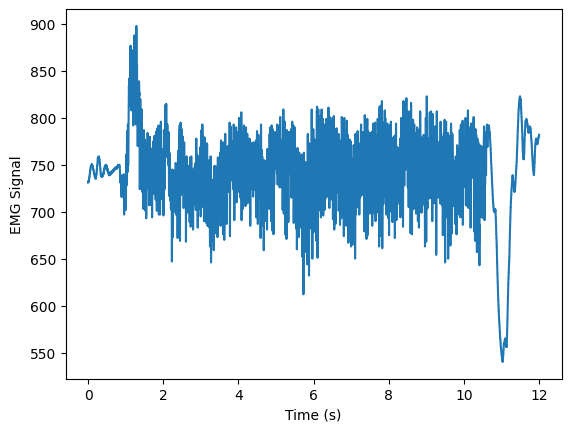

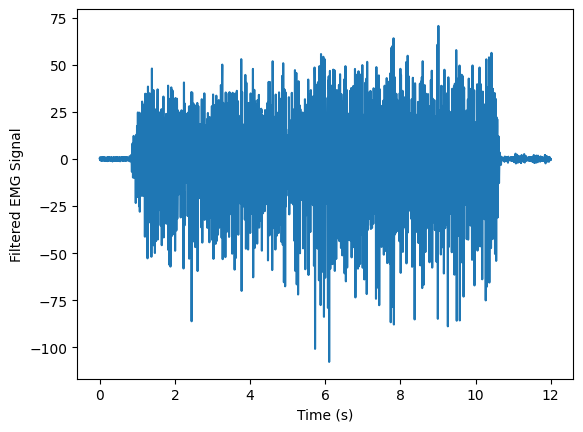

In [16]:
import pandas as pd
dfRad = pd.read_csv('arduino_log.csv', sep = ';', header = 0, names = ['Frames' , 'EMG'], index_col = 0)
#show the signal in the correct time frame
import matplotlib.pyplot as plt
# Compute time vector
time = dfRad.index / sampling_rate

mid_time = time[len(time) // 2]
# Select the 1-second window around the center

# Plot
plt.plot(time, dfRad['EMG'])
plt.xlabel('Time (s)')
plt.ylabel('EMG Signal')
plt.show()

#low pass filter
from scipy.signal import butter, filtfilt
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

#define high pass filter
def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

# Apply high pass filter
cutoff_high = 20.0  # desired cutoff frequency of the filter, Hz
b_high, a_high = butter_highpass(cutoff_high, sampling_rate, order=4)
filtered_high = filtfilt(b_high, a_high, dfRad['EMG'])

# Apply low pass filter
cutoff_low = 450.0  # desired cutoff frequency of the filter, Hz
b_low, a_low = butter_lowpass(cutoff_low, sampling_rate, order=4)
filtered_signal = filtfilt(b_low, a_low, filtered_high)
# Plot filtered signal
plt.plot(time, filtered_signal)
plt.xlabel('Time (s)')
plt.ylabel('Filtered EMG Signal')
plt.show()